In [72]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd

from util import engineer_features

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)
df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)

df = df[df["therapy_week"].between(0, 20)]
df_train = df[df["Arm_Sham"]]
df_test = df[~df["Arm_Sham"]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/gv/lj5cf4w14fqc6937ndlg7qb40000gr/T/ipykernel_45408/166797151.py:11: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [ ]:
import matplotlib.pyplot as plt

active_hours = (7, 20)
feature = "hr_moving_avg_10m"
df_test = df_test[
    df_test["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1])
]

In [74]:
print(f"Training samples : {len(df_train)}, Test samples : {len(df_test)}")
print(
    f"Training positive cases : {df_train['tantrum_within_60m'].sum()}, Test positive cases : {df_test['tantrum_within_60m'].sum()}"
)

Training samples : 177232, Test samples : 135998
Training positive cases : 757, Test positive cases : 1652


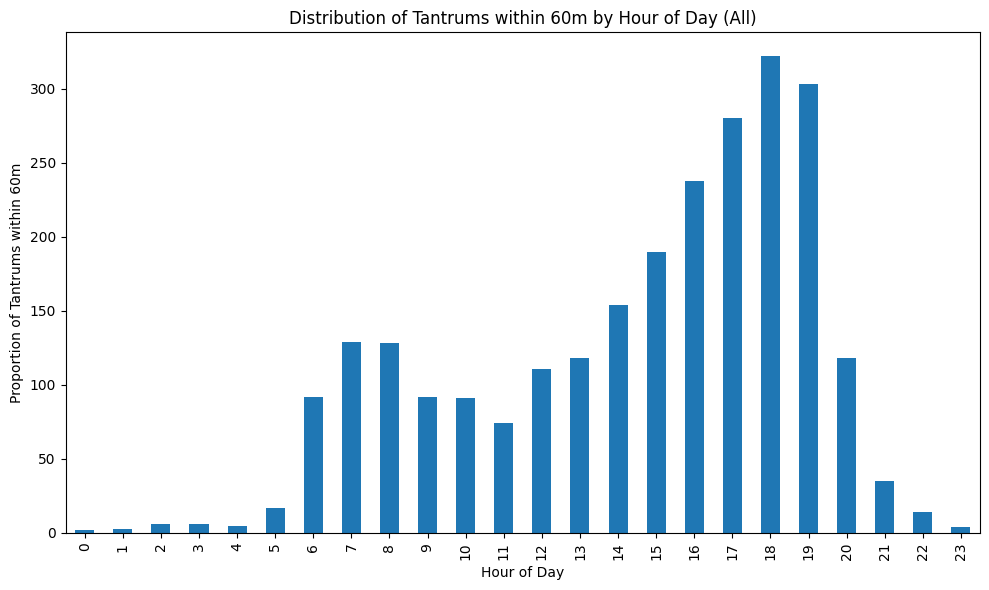

In [76]:
df["hour"] = df["ActivityDateTime"].dt.hour
plt.figure(figsize=(10, 6))
df.groupby("hour")["tantrum_within_60m"].sum().plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Proportion of Tantrums within 60m")
plt.title("Distribution of Tantrums within 60m by Hour of Day (All)")
plt.tight_layout()
plt.show()

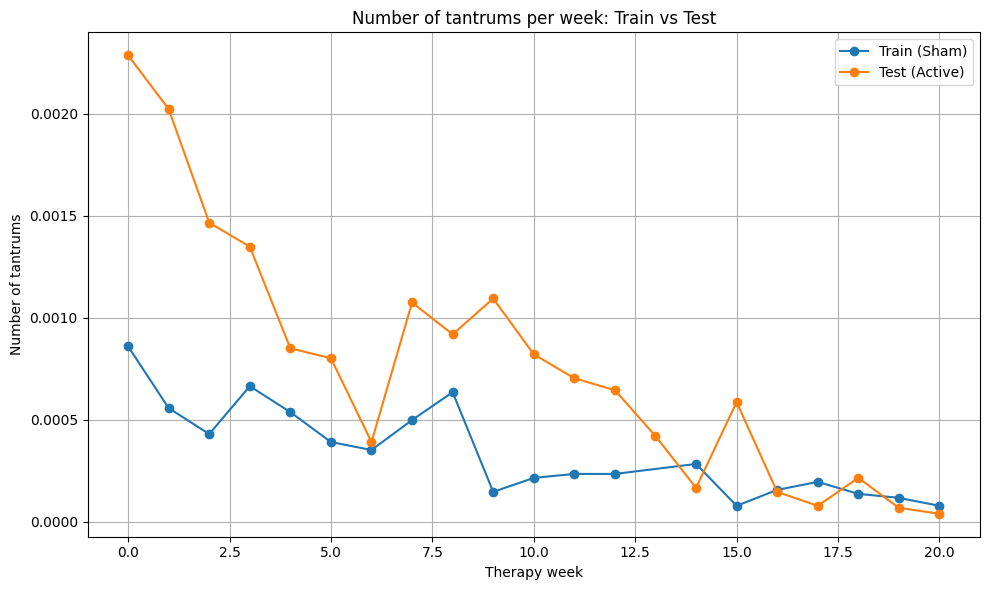

In [46]:
# Count number of tantrums per week for train and test sets
tantrums_train = df_train[df_train["tantrum_within_60m"]].groupby(
    "therapy_week"
).size() / len(df_train)
tantrums_test = df_test[df_test["tantrum_within_60m"]].groupby(
    "therapy_week"
).size() / len(df_train)

plt.figure(figsize=(10, 6))
plt.plot(tantrums_train.index, tantrums_train.values, marker="o", label="Train (Sham)")
plt.plot(tantrums_test.index, tantrums_test.values, marker="o", label="Test (Active)")
plt.xlabel("Therapy week")
plt.ylabel("Number of tantrums")
plt.title("Number of tantrums per week: Train vs Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

R^2: 0.011


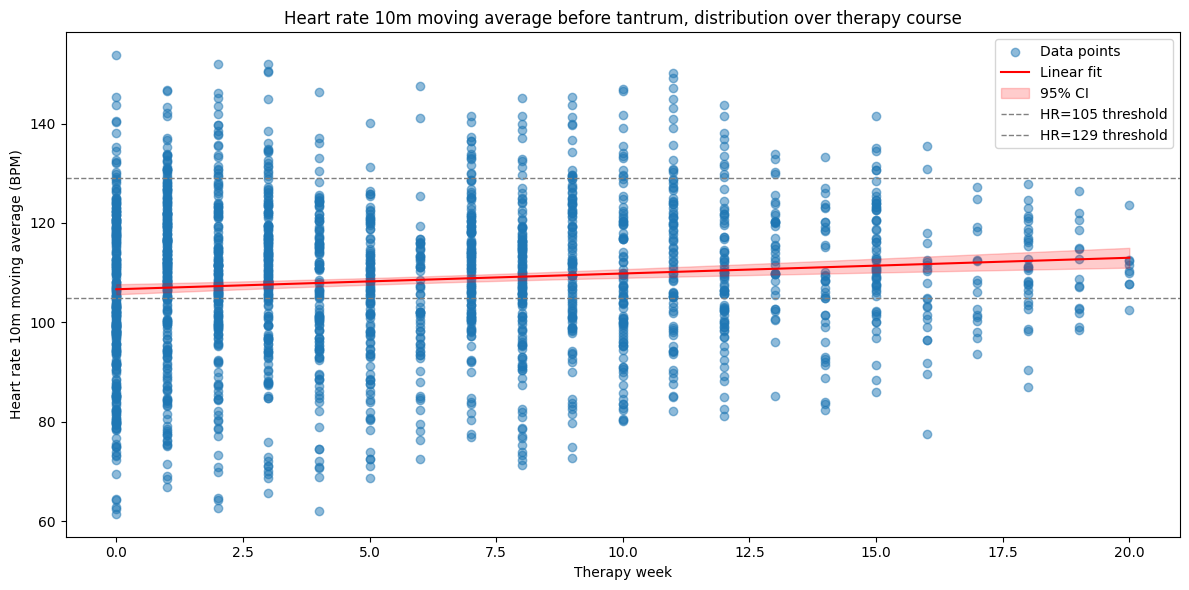

In [55]:
import numpy as np
from scipy import stats

df_cases = df_all[df_all["tantrum_within_60m"]]
# Drop NaNs for regression
df_cases_clean = df_cases.dropna(subset=["therapy_week", feature])
df_cases_clean = df_cases_clean.sort_values("therapy_week")

x = df_cases_clean["therapy_week"].values
y = df_cases_clean[feature].values

# Fit linear regression using numpy
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# Calculate 95% CI for regression line
n = len(x)
y_err = y - y_pred
s_err = np.sqrt(np.sum(y_err**2) / (n - 2))
t_val = stats.t.ppf(0.975, n - 2)
ci = (
    t_val
    * s_err
    * np.sqrt(1 / n + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2))
)

# Calculate R^2 for the linear fit
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared:.3f}")

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.5, label="Data points")
plt.plot(x, y_pred, color="red", label="Linear fit")
plt.fill_between(x, y_pred - ci, y_pred + ci, color="red", alpha=0.2, label="95% CI")
plt.xlabel("Therapy week")
plt.ylabel("Heart rate 10m moving average (BPM)")
plt.axhline(105, color="gray", linestyle="--", linewidth=1, label="HR=105 threshold")
plt.axhline(129, color="gray", linestyle="--", linewidth=1, label="HR=129 threshold")

plt.title(
    "Heart rate 10m moving average before tantrum, distribution over therapy course"
)
plt.legend()
plt.tight_layout()
plt.show()